In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from mocap_labels import WALK_TRIALS, RUN_TRIALS, __walk_trials, __run_trials
from gpdm_marginalized import GPDM_Marginalized
from gpdm import GPDM
import select_joints
import timeit

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
reduced_columns = WALK_TRIALS[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)

In [3]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP

Training GPDM (impl 1) for subject 7 trial 8...
Elapsed time: 26.695982200093567


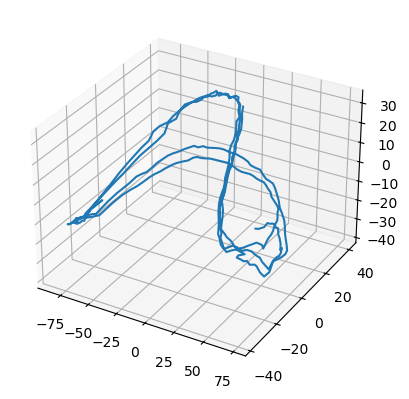

Training GPDM (impl 2) for subject 7 trial 8...

### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 4.7166e+06
Update time: 0.216355562210083

GPDM Opt. EPOCH: 10
Running loss: 3.7218e+06
Update time: 1.464721441268921

GPDM Opt. EPOCH: 20
Running loss: 2.9211e+06
Update time: 0.9833216667175293

GPDM Opt. EPOCH: 30
Running loss: 2.2778e+06
Update time: 0.8516790866851807

GPDM Opt. EPOCH: 40
Running loss: 1.7680e+06
Update time: 1.10109543800354

GPDM Opt. EPOCH: 50
Running loss: 1.3871e+06
Update time: 0.9134421348571777

GPDM Opt. EPOCH: 60
Running loss: 1.1192e+06
Update time: 0.8164761066436768

GPDM Opt. EPOCH: 70
Running loss: 9.3005e+05
Update time: 0.6704957485198975

GPDM Opt. EPOCH: 80
Running loss: 7.8947e+05
Update time: 0.7125718593597412

GPDM Opt. EPOCH: 90
Running loss: 6.7897e+05
Update time: 1.1334915161132812
Elapsed time: 11.874844500096515


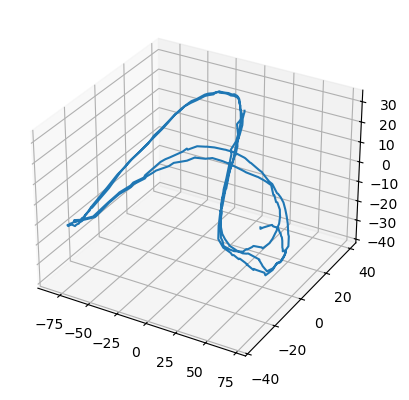

Training GPDM (impl 1) for subject 7 trial 6...


In [ ]:

# Select 5 random trials and train a GPDM for each
# Then, plot the latent space for each trial

random_walk_mocaps = random.sample(WALK_TRIALS, 5)

walking_gpdm_trajectories = []
for mocap in random_walk_mocaps:

    print(f"Training GPDM (impl 1) for subject {mocap.subject} trial {mocap.trial}...")

    arr = mocap.as_dataframe()[reduced_columns].to_numpy().astype(np.float64)

    start_time = timeit.default_timer()
    gpdm = GPDM_Marginalized(arr, d)
    gpdm.fit()
    latent_trajectory = gpdm.X_map
    end_time = timeit.default_timer()
    print(f"Elapsed time: {end_time - start_time}")
  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(latent_trajectory[:, 0], latent_trajectory[:, 1], latent_trajectory[:, 2])
    plt.show()

    print(f"Training GPDM (impl 2) for subject {mocap.subject} trial {mocap.trial}...")

    start_time = timeit.default_timer()
    gpdm = GPDM(
        D=DOFs,
        d=d,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )
    gpdm.add_data(arr)
    gpdm.init_X()
    gpdm.train_adam(100, 10, 1e-2)
    latent_trajectory = gpdm.X.clone().detach().numpy()
    end_time = timeit.default_timer()
    print(f"Elapsed time: {end_time - start_time}")
  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(latent_trajectory[:, 0], latent_trajectory[:, 1], latent_trajectory[:, 2])
    plt.show()



In [29]:
# Repeat for running trials

random_run_mocaps = random.sample(RUN_TRIALS, 5)

running_gpdm_trajectories = []
for mocap in random_run_mocaps:

    print(f"Training GPDM for subject {mocap.subject} trial {mocap.trial}...")

    arr = mocap.as_dataframe()[reduced_columns].to_numpy().astype(np.float64)
    gpdm = GPDM_Marginalized(arr, 3)
    gpdm.fit()
    latent_trajectory = gpdm.X_map
  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(latent_trajectory[:, 0], latent_trajectory[:, 1], latent_trajectory[:, 2])
    plt.show()


Training GPDM for subject 35 trial 24...


KeyboardInterrupt: 